# Deep Learning I

## Table of contents

0. Before we start

1. Gradient Descend

2. From derivatives to gradient: $n$-dimensional function minimization

3. How to learn from data?

    3.1 Square / Euclidean Loss
    
    3.2 Hinge / Margin Loss (i.e. Suport Vector Machines)
    
    3.3 Logistic Loss (Logistic Regression)
    
    3.4 Sigmoid Cross-Entropy Loss (Softmax classifier)
    
4. Batch Gradient Descend

    4.1 Mini-batch Gradient Descent
    
5. Automatic Differentiation

## 0. Before we start

The most simple thing we can try to minimize a function $f(x)$ would be to sample two points relatively near each other, and just repeatedly take a step down away from the largest value. This simple algorithm has a severe limitation: it can't get closer to the true minima than the step size.

The **Nelder-Mead** method dynamically adjusts the step size based off the loss of the new point. If the new point is better than any previously seen value, it expands the step size to accelerate towards the bottom. Likewise if the new point is worse it contracts the step size to converge around the minima. The usual settings are to half the step size when contracting and double the step size when expanding.

This method can be easily extended into higher dimensional examples, all that's required is taking one more point than there are dimensions. Then, the simplest approach is to replace the worst point with a point reflected through the centroid of the remaining n points. If this point is better than the best current point, then we can try stretching exponentially out along this line. On the other hand, if this new point isn't much better than the previous value, then we are stepping across a valley, so we shrink the step towards a better point.

> See ["An Interactive Tutorial on Numerical Optimization"](http://www.benfrederickson.com/numerical-optimization/)

Questions:

+ What are the limitations of this method from a computational point of view?
+ In which cases is a real alternative?

**Gradient-based** optimization methods provide an alternative to sampling approaches.

## 1. Gradient Descend

Gradient Descend

Let's suppose that we have a function $f(w): \mathbf{R} \rightarrow \mathbf{R}$ and that our objective is to find the argument  $w$ that minimizes this function (for maximization, consider $-f(w)$). To this end, the critical concept is the *derivative*.

The derivative of $f$ of a variable $w$, $ f'(w)$ or $\frac{\delta f}{\delta  w}$,  is a measure of the rate at which the value of the function changes with respect to the change of the variable. It is defined as the following limit:


$$ f'(w) = \lim_{h \rightarrow 0} \frac{f(w + h) - f(w)}{h} $$

The derivative specifies how to scale a small change in the input in order to obtain the corresponding change in the output. Knowing the value of $f(w)$ at a point $w$, this allows to predict the value of the function in a neighboring point:

$$ f(w + h) \approx f(w) + h f'(w)$$


### First approach

Then, by following these steps we can decrease the value of the function:

+ Start from a random $w^0$ value.
+ Compute the derivative $f'(w) = \lim_{h \rightarrow 0} \frac{f(w + h) - f(w)}{h}$.
+ Walk small steps in the opposite direction of the derivative, $w^{i+1} = w^i - h f'(w^i)$, because we know that $f(w - h f'(w))$ is less than $f(w)$ for  small enough $h$, until $ f'(w) \approx 0$.

The search for the minima ends when the derivative is zero because we have no more information about which direction to move. $w$ is called a critical or stationary point of $f(w)$ if $f'(w)=0$. 

All extrema points (maxima/minima) are critical points because $f(w)$ is lower/higher than at all neighboring points. But these are not the only critical points: there is a third class of critical points called *saddle points*. Saddle points are points that have partial derivatives equal to zero but at which the function has neither a maximum nor a minimum value.

If $f$ is a *convex function*, when the derivative is zero this should be the extremum of our function. In other cases it could be a local minimum/maximum or a saddle point.

In [1]:
# numerical derivative at a point x by using finite differences

def f(x):
    return x**2

def fin_dif(x, 
            f, 
            h = 0.00001):
    '''
    This method returns the derivative of f at x
    by using the finite difference method
    '''
    return (f(x+h) - f(x))/h

x = 2.0
print("{:2.4f}".format(fin_dif(x,f)))

4.0000


> NOTE: It can be shown that the “centered difference formula" is better when computing numerical derivatives:

> $$ \lim_{h \rightarrow 0} \frac{f(x + h) - f(x - h)}{2h} $$
The error in the "finite difference" approximation can be derived from Taylor's theorem and, assuming that $f$ is differentiable, is $O(h)$. In the case of “centered difference" the error is $O(h^2)$.

There are two problems with numerical derivatives:

+ It is approximate.
+ It is very slow to evaluate (two function evaluations: $f(x + h) , f(x - h)$ ).

Our knowledge from Calculus could help!



### Second approach

To find the local minimum using gradient descend and in the case of knowing an analytical expression of the derivative of the **function** we want to minimize, you can start at a random point, and move into the direction of steepest descent relative to the derivative:

+ Start from a random $x$ value.
+ Compute the derivative $f'(x)$ analitically.
+ Walk a small step in the opposite direction of the derivative.

<function matplotlib.pyplot.show(close=None, block=None)>

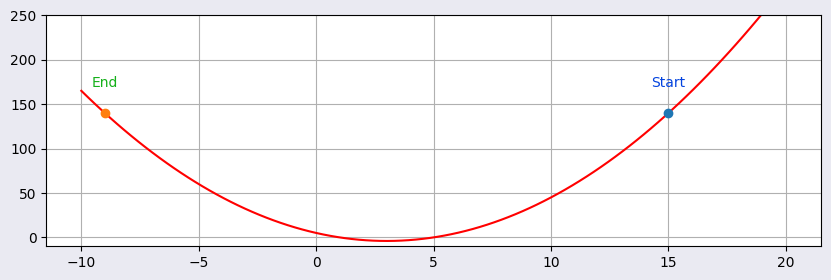

In [2]:
#@title Default title text
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression 
from scipy import stats 
%matplotlib inline

x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5
start = 15

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
plt.plot(x,y, 'r-')
plt.plot([start],[start**2 - 6*start + 5],'o')
ax.text(start,
        start**2 - 6*start + 35,
        'Start',
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )

d = 2 * start - 6
end = start - d

plt.plot([end],[end**2 - 6*end + 5],'o')
plt.ylim([-10,250])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
ax.text(end,
        start**2 - 6*start + 35,
        'End',
        ha='center',
        color=sns.xkcd_rgb['green'],
       )
plt.show

**There is a problem! Which one?**

We need to define a suitable *step* to modulate the value of the gradient.

In [3]:
old_min = 0
temp_min = 15
step_size = 0.1
precision = 0.0001

def f(x):
    return x**2 - 6*x + 5
    
def f_derivative(x):
    import math
    return 2*x -6

mins = []
cost = []

while abs(temp_min - old_min) > precision:
    old_min = temp_min 
    gradient = f_derivative(old_min) 
    move = gradient * step_size
    temp_min = old_min - move
    print("Temp minimum occurs at {:3.6f}.".format(round(temp_min,2)))
    cost.append((3-temp_min)**2)
    mins.append(temp_min)

# rounding the result to 2 digits because of the step size
print("Local minimum occurs at {:3.6f}.".format(round(temp_min,2)))

Temp minimum occurs at 12.600000.
Temp minimum occurs at 10.680000.
Temp minimum occurs at 9.140000.
Temp minimum occurs at 7.920000.
Temp minimum occurs at 6.930000.
Temp minimum occurs at 6.150000.
Temp minimum occurs at 5.520000.
Temp minimum occurs at 5.010000.
Temp minimum occurs at 4.610000.
Temp minimum occurs at 4.290000.
Temp minimum occurs at 4.030000.
Temp minimum occurs at 3.820000.
Temp minimum occurs at 3.660000.
Temp minimum occurs at 3.530000.
Temp minimum occurs at 3.420000.
Temp minimum occurs at 3.340000.
Temp minimum occurs at 3.270000.
Temp minimum occurs at 3.220000.
Temp minimum occurs at 3.170000.
Temp minimum occurs at 3.140000.
Temp minimum occurs at 3.110000.
Temp minimum occurs at 3.090000.
Temp minimum occurs at 3.070000.
Temp minimum occurs at 3.060000.
Temp minimum occurs at 3.050000.
Temp minimum occurs at 3.040000.
Temp minimum occurs at 3.030000.
Temp minimum occurs at 3.020000.
Temp minimum occurs at 3.020000.
Temp minimum occurs at 3.010000.
Temp min

<function matplotlib.pyplot.show(close=None, block=None)>

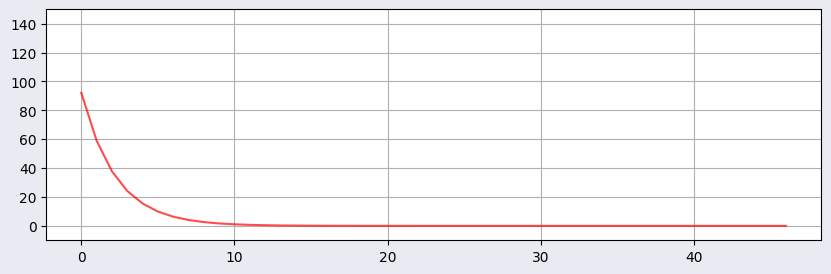

In [4]:
x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5

x, y = (zip(*enumerate(cost)))

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
plt.plot(x,y, 'r-', alpha=0.7)
plt.ylim([-10,150])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

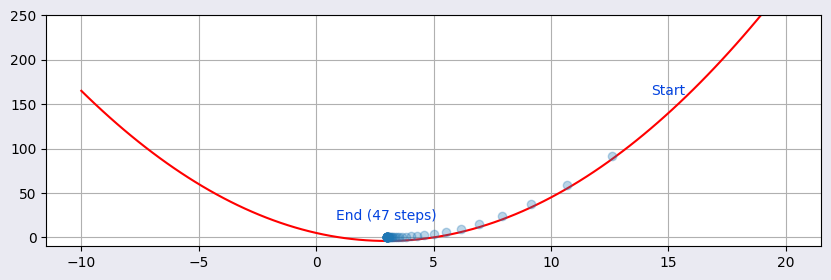

In [5]:
x = np.linspace(-10,20,100)
y = x**2 - 6*x + 5

fig, ax = plt.subplots(1, 1)
fig.set_facecolor('#EAEAF2')
plt.plot(x,y, 'r-')
plt.ylim([-10,250])
plt.gcf().set_size_inches((10,3))
plt.grid(True)
plt.plot(mins,cost,'o', alpha=0.3)
ax.text(start,
        start**2 - 6*start + 25,
        'Start',
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )
ax.text(mins[-1],
        cost[-1]+20,
        'End (%s steps)' % len(mins),
        ha='center',
        color=sns.xkcd_rgb['blue'],
       )
plt.show

### Alpha

The step size, **alpha**, is a slippy concept: if it is too small we will slowly converge to the solution, if it is too large we can diverge from the solution. 

There are several policies to follow when selecting the step size:

+ Constant size steps. In this case, the size step determines the precision of the solution.
+ Decreasing step sizes.
+ At each step, select the optimal step.

The last policy is good, but too expensive.

## 2. From derivatives to gradient: $n$-dimensional function minimization

Let's consider a $n$-dimensional function $f: \mathbf{R}^n \rightarrow \mathbf{R}$. For example:

$$f(\mathbf{x}) = \sum_{n} x_n^2$$
Our objective is to find the argument  $\mathbf{x}$ that minimizes this function.

The gradient of $f$ is the vector whose components are the $n$ partial derivatives of $f$. It is thus a vector-valued function.

The gradient points in the direction of the greatest rate of increase of the function.

$$\nabla {f} = (\frac{\partial f}{\partial x_1}, \dots, \frac{\partial f}{\partial x_n})$$

In [6]:
def f(x):
    return sum(x_i**2 for x_i in x)

def fin_dif_partial_centered(x, 
                             f, 
                             i, 
                             h=1e-6):
    '''
    This method returns the partial derivative of the i-th 
    component of f at x
    by using the centered finite difference method
    '''
    w1 = [x_j + (h if j==i else 0) for j, x_j in enumerate(x)]
    w2 = [x_j - (h if j==i else 0) for j, x_j in enumerate(x)]
    return (f(w1) - f(w2))/(2*h)

def gradient_centered(x, 
                      f, 
                      h=1e-6):
    '''
    This method returns the gradient vector of f at x
    by using the centered finite difference method
    '''
    return[round(fin_dif_partial_centered(x,f,i,h), 10) for i,_ in enumerate(x)]


x = [1.0,1.0,1.0]

print('{:.6f}'.format(f(x)), gradient_centered(x,f))

3.000000 [2.0000000001, 2.0000000001, 2.0000000001]


The function we have evaluated, $f({\mathbf x}) = x_1^2+x_2^2+x_3^2$, is $3$ at $(1,1,1)$ and the gradient vector at this point is $(2,2,2)$. 

Then, we can follow this steps to maximize (or minimize) the function:

+ Start from a random $\mathbf{x}$ vector.
+ Compute the gradient vector.
+ Walk a small step in the opposite direction of the gradient vector.

> It is important to be aware that this gradient computation is very expensive: if $\mathbf{x}$ has dimension $n$, we have to evaluate $f$ at $2*n$ points.


## 3. How to learn from data?

Learn frmo Data

In general, *Learning from Data* is a scientific discipline that is concerned with the design and development of algorithms that allow computers to infer, from data, a model that allows a compact representation of raw data and/or good generalization abilities. In the former case we are talking about non supervised learning. In the later, supervised learning. 

This is nowadays an important technology because it enables computational systems to improve their performance with experience accumulated from the observed data in real world scenarios.

Let's consider the supervised learning problem from an optimization point of view. When learning a model from data the most common scenario is composed of the following elements:

+ A dataset $(\mathbf{x},y)$ of $n$ examples. For example, $(\mathbf{x},y)$ can represent:

  + $\mathbf{x}$: the behavior of a game player; $y$: monthly payments.
  + $\mathbf{x}$: sensor data about your car engine; $y$: probability of engine error.
  + $\mathbf{x}$: financial data of a bank customer; $y$: customer rating.

  If $y$ is a real value, the problem we are trying to solve is called a *regression* problem. If $y$ is binary or categorical, it is called a *classification* problem.

+ A target function $f_{(\mathbf{x},y)}(\mathbf{w})$, that we want to minimize, representing the discrepancy between our data and the model we want to fit.

+ A model $M$ that is represented by a set of parameters $\mathbf{w}$.

+ The gradient of the target function, $\nabla {f_{(\mathbf{x},y)}(\mathbf{w})}$ with respect to model parameters.

In the case of regression $f_{(\mathbf{x},y)}(\mathbf{w})$ represents the errors from a data representation model $M$. Fitting a model can be defined as finding the optimal parameters $\mathbf{w}$ that minimize the following expression:

$f_{(\mathbf{x},y)}(\mathbf{w}) = \frac{1}{n} \sum_{i} (y_i - M(\mathbf{x}_i,\mathbf{w}))^2$

Alternative regression and classification problems can be defined by considering different formulations to measure the errors from a data representation model. These formulations are known as the *Loss Function* of the problem. 


### 3.1 Square / Euclidean Loss

In regression problems, the most common loss function is the square loss function:

$$ L(y, f(\mathbf{x})) = \frac{1}{n} \sum_i (y_i - f(\mathbf{x}_i))^2  $$

The square loss function can be re-written and utilized for classification:

$$ L(y, f(\mathbf{x})) = \frac{1}{n} \sum_i (1 - y_i f(\mathbf{x}_i))^2  $$


### 3.2 Hinge / Margin Loss (i.e. Support Vector Machines)

The hinge loss function is defined as:

$$ L(y, f(\mathbf{x})) = \frac{1}{n} \sum_i \max(0, 1 - y_i f(\mathbf{x}_i)) $$

The hinge loss provides a relatively tight, convex upper bound on the 0–1 Loss.

### 3.3 Logistic Loss (Logistic Regression)

This function displays a similar convergence rate to the hinge loss function, and since it is continuous, simple gradient descent methods can be utilized. 

$$ L(y, f(\mathbf{x})) = \frac{1}{n} log(1 + exp(-y_i f(\mathbf{x}_i))) $$


### 3.4 Sigmoid Cross-Entropy Loss (Softmax classifier)

Cross-Entropy is a loss function that is very used for training **multiclass problems**. We'll focus on models that assume that classes are mutually exclusive. 

In this case, our labels have this form $\mathbf{y}_i =(1.0,0.0,0.0)$. If our model predicts a different distribution, say  $ f(\mathbf{x}_i)=(0.4,0.1,0.5)$, then we'd like to nudge the parameters so that $f(\mathbf{x}_i)$ gets closer to $\mathbf{y}_i$.

C.Shannon showed that if you want to send a series of messages composed of symbols from an alphabet with distribution $y$ ($y_j$  is the probability of the  $j$-th symbol), then to use the smallest number of bits on average, you should assign  $\log(\frac{1}{y_j})$  bits to the  $j$-th symbol. 

The optimal number of bits is known as **entropy**:

$$ H(\mathbf{y}) = \sum_j y_j \log\frac{1}{y_j} = - \sum_j y_j \log y_j$$

**Cross entropy** is the number of bits we'll need if we encode symbols by using a wrong distribution $\hat y$:

$$ H(y, \hat y) =   - \sum_j y_j \log \hat y_j $$ 

In our case, the real distribution is $\mathbf{y}$ and the "wrong" one is $f(\mathbf{x}_i)$. So, minimizing **cross entropy** with respect our model parameters will result in the model that best approximates our labels if considered as a probabilistic distribution. 

Cross entropy is used in combination with **Softmax** classifier. In order to classify $\mathbf{x}_i$ we could take the index corresponding to the max value of $f(\mathbf{x}_i)$, but Softmax gives a slightly more intuitive output (normalized class probabilities) and also has a probabilistic interpretation:

$$ P(\mathbf{y}_i = j \mid \mathbf{x_i}) = - log \left( \frac{e^{f_j(\mathbf{x_i})}}{\sum_k e^{f_k(\mathbf{x_i})} } \right) $$

where $f_k$ is a linear classifier. 


## 4. Batch gradient descend

We can implement **gradient descend** in the following way (*batch gradient descend*):

In [7]:
import numpy as np
import random

# f = 2x
x = np.arange(10)
y = np.array([2*i for i in x])

# f_target = 1/n Sum (y - wx)**2
def target_f(x,y,w):
    return np.sum((y - x * w)**2.0) / x.size

# gradient_f = 2/n Sum 2wx**2 - 2xy
def gradient_f(x,y,w):
    return 2 * np.sum(2*w*(x**2) - 2*x*y) / x.size

def step(w,grad,alpha):
    return w - alpha * grad

def BGD(target_f, 
        gradient_f, 
        x, 
        y, 
        toler = 1e-6, 
        alpha=0.01):
    '''
    Batch gradient descend by using a given step
    '''
    w = random.random()
    val = target_f(x,y,w)
    i = 0
    while True:
        i += 1
        gradient = gradient_f(x,y,w)
        next_w = step(w, gradient, alpha)
        next_val = target_f(x,y,next_w)    
        if (abs(val - next_val) < toler):
            return w
        else:
            w, val = next_w, next_val
            
print('{:.6f}'.format(BGD(target_f, gradient_f, x, y)))

2.000057


#### Stochastic Gradient Descend

The last function evals the whole dataset $(\mathbf{x}_i,y_i)$ at every step. 

If the dataset is large, this strategy is too costly. In this case we will use a strategy called **SGD** (*Stochastic Gradient Descend*).

When learning from data, the cost function is additive: it is computed by adding sample reconstruction errors. 

Then, we can compute the estimate the gradient (and move towards the minimum) by using only **one data sample** (or a small data sample).

Thus, we will find the minimum by iterating this gradient estimation over the dataset.

A full iteration over the dataset is called **epoch**. During an epoch, data must be used in a random order.

If we apply this method we have some theoretical guarantees to find a good minimum:
+ SGD essentially uses the inaccurate gradient per iteration. Since there is no free food, what is the cost by using approximate gradient? The answer is that the convergence rate is slower than the gradient descent algorithm.
+ The convergence of SGD has been analyzed using the theories of convex minimization and of stochastic approximation: it converges almost surely to a global minimum when the objective function is convex or pseudoconvex, and otherwise converges almost surely to a local minimum.

In [8]:
import numpy as np
x = np.arange(10)
y = np.array([2*i for i in x])
data = list(zip(x,y))

for (x_i,y_i) in data:
    print('{:3d} {:3d}'.format(x_i,y_i))
print("")

def in_random_order(data):
    '''
    Random data generator
    '''
    import random
    indexes = [i for i,_ in enumerate(data)]
    random.shuffle(indexes)
    for i in indexes:
        yield data[i]
        
import numpy as np
import random

def SGD(target_f, 
        gradient_f, 
        x, 
        y, 
        toler = 1e-6, 
        epochs=100, 
        alpha_0=0.01):
    '''
    Stochastic gradient descend with automatic step adaptation (by
    reducing the step to its 95% when there are iterations with no increase)
    '''
    data = list(zip(x,y))
    w = random.random()
    alpha = alpha_0
    min_w, min_val = float('inf'), float('inf')
    epoch = 0
    iteration_no_increase = 0
    while epoch < epochs and iteration_no_increase < 100:
        val = target_f(x, y, w)
        if min_val - val > toler:
            min_w, min_val = w, val
            alpha = alpha_0
            iteration_no_increase = 0
        else:
            iteration_no_increase += 1
            alpha *= 0.95
        for x_i, y_i in list(in_random_order(data)):
            gradient_i = gradient_f(x_i, y_i, w)
            w = w - (alpha *  gradient_i)
        epoch += 1
    return min_w
  
print('w: {:.6f}'.format(SGD(target_f, gradient_f, x, y)))

  0   0
  1   2
  2   4
  3   6
  4   8
  5  10
  6  12
  7  14
  8  16
  9  18

w: 2.000000


### 4.1 Mini-batch Gradient Descent

In code, general batch gradient descent looks something like this:

```python
nb_epochs = 100
for i in range(nb_epochs):
    grad = evaluate_gradient(target_f, data, w)
    w = w - learning_rate * grad
```

For a pre-defined number of epochs, we first compute the gradient vector of the target function for the whole dataset w.r.t. our parameter vector. 

**Stochastic gradient descent** (SGD) in contrast performs a parameter update for each training example and label:

```python
nb_epochs = 100
for i in range(nb_epochs):
    np.random.shuffle(data)
    for sample in data:
        grad = evaluate_gradient(target_f, sample, w)
        w = w - learning_rate * grad
```

Mini-batch gradient descent finally takes the best of both worlds and performs an update for every mini-batch of $n$ training examples:

```python
nb_epochs = 100
for i in range(nb_epochs):
  np.random.shuffle(data)
  for batch in get_batches(data, batch_size=50):
    grad = evaluate_gradient(target_f, batch, w)
    w = w - learning_rate * grad
```

Minibatch SGD has the advantage that it works with a slightly less noisy estimate of the gradient. However, as the minibatch size increases, the number of updates done per computation done decreases (eventually it becomes very inefficient, like batch gradient descent). 

There is an optimal trade-off (in terms of computational efficiency) that may vary depending on the data distribution and the particulars of the class of function considered, as well as how computations are implemented.

## EXTRA 5. Automatic Differentiation

> The **backpropagation** algorithm was originally introduced in the 1970s, but its importance wasn't fully appreciated until a famous 1986 paper by David Rumelhart, Geoffrey Hinton, and Ronald Williams. (Michael Nielsen in "Neural Networks and Deep Learning", http://neuralnetworksanddeeplearning.com/chap2.html).

> **Backpropagation** is the key algorithm that makes training deep models computationally tractable. For modern neural networks, it can make training with gradient descent as much as ten million times faster, relative to a naive implementation. That’s the difference between a model taking a week to train and taking 200,000 years. (Christopher Olah, 2016)

We have seen that in order to optimize our models we need to compute the derivative of the loss function with respect to all model paramaters. 

The computation of derivatives in computer models is addressed by four main methods: 

+ manually working out derivatives and coding the result (as in the original paper describing backpropagation); 
+ numerical differentiation (using finite difference approximations); 
+ symbolic differentiation (using expression manipulation in software, such as Sympy); 
+ and automatic differentiation (AD).

**Automatic differentiation** (AD) works by systematically applying the **chain rule** of differential calculus at the elementary operator level.

Let $ y = f(g(x)) $ our target function. In its basic form, the chain rule states:

$$ \frac{\partial y}{\partial x} = \frac{\partial y}{\partial g} \frac{\partial g}{\partial x} $$

or, if there are more than one variable $g_i$ in-between $y$ and $x$ (f.e. if $f$ is a two dimensional function such as $f(g_1(x), g_2(x))$), then:

$$ \frac{\partial y}{\partial x} = \sum_i \frac{\partial y}{\partial g_i} \frac{\partial g_i}{\partial x} $$

> See https://www.math.hmc.edu/calculus/tutorials/multichainrule/

Now, let's see how AD allows the accurate evaluation of derivatives at machine precision, with only a small constant factor of overhead.

In its most basic description, AD relies on the fact that all numerical computations
are ultimately compositions of a finite set of elementary operations for which derivatives are known.

For example, let's consider the computation of the derivative of this function, that represents a 1-layer neural network model:

$$
    f(x) = \frac{1}{1 + e^{- ({w}^T \cdot  x + b)}} 
$$


First, let's write how to evaluate $f(x)$ via a sequence of primitive operations:


```python
x = ?
f1 = w * x
f2 = f1 + b
f3 = -f2
f4 = 2.718281828459 ** f3
f5 = 1.0 + f4
f = 1.0/f5
```

The question mark indicates that $x$ is a value that must be provided. 

This *program* can compute the value of $x$ and also **populate program variables**. 

We can evaluate $\frac{\partial f}{\partial x}$ at some $x$ by using the chain rule. This is called *forward-mode differentiation*. 

In our case:

In [9]:
def f(x,w,b):
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = 2.718281828459 ** f3
    f5 = 1.0 + f4
    return 1.0/f5

def dfdx_forward(x, w, b):
    f1 = w * x
    p1 = w                            # p1 = df1/dx
    f2 = f1 + b
    p2 = p1 * 1.0                     # p2 = p1 * df2/df1 
    f3 = -f2
    p3 = p2 * -1.0                    # p3 = p2 * df3/df2
    f4 = 2.718281828459 ** f3
    p4 = p3 * 2.718281828459 ** f3    # p4 = p3 * df4/df3
    f5 = 1.0 + f4
    p5 = p4 * 1.0                     # p5 = p4 * df5/df4
    f = 1.0/f5
    df = p5 * -1.0 / f5 ** 2.0        # df/dx = p5 * df/df5
    return f, df

der = (f(3+0.00001, 2, 1) - f(3, 2, 1))/0.00001

print("Value of the function at (3, 2, 1): ",f(3, 2, 1))
print("df/dx Derivative (fin diff) at (3, 2, 1): ",der)
print("df/dx Derivative (aut diff) at (3, 2, 1): ",dfdx_forward(3, 2, 1)[1])

Value of the function at (3, 2, 1):  0.9990889488055992
df/dx Derivative (fin diff) at (3, 2, 1):  0.0018204242002717306
df/dx Derivative (aut diff) at (3, 2, 1):  0.0018204423602438651


It is interesting to note that this *program* can be automatically derived  if we have access to **subroutines implementing the derivatives of primitive functions** (such as $\exp{(x)}$ or $1/x$) and all intermediate variables are computed in the right order. 

It is also interesting to note that AD allows the accurate evaluation of derivatives at **machine precision**, with only a small constant factor of overhead.

Forward differentiation is efficient for functions $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $n << m$ (only $O(n)$ sweeps are necessary). 

For cases $n >> m$ a different technique is needed. To this end, we will rewrite the chain rule as:

$$
\frac{\partial f}{\partial x} = \frac{\partial g}{\partial x} \frac{\partial f}{\partial g}
$$

to propagate derivatives backward from a given output. This is called *reverse-mode differentiation*. Reverse pass starts at the end (i.e. $\frac{\partial f}{\partial f} = 1$) and propagates backward to all dependencies.



In [10]:
def dfdx_backward(x, w, b):
    import numpy as np
    f1 = w * x
    f2 = f1 + b
    f3 = -f2
    f4 = 2.718281828459 ** f3
    f5 = 1.0 + f4
    f = 1.0/f5
    
    pf = 1.0                           # pf = df/df
    p5 = 1.0 * -1.0 / (f5 * f5) * pf   # p5 = pf * df/df5 
    p4 = p5 * 1.0                      # p4 = p5 * df5/df4
    p3 = p4 * np.log(2.718281828459) \
          * 2.718281828459 ** f3       # p3 = p4 * df4/df3
    p2 = p3 * -1.0                     # p2 = p3 * df3/df2
    p1 = p2 * 1.0                      # p1 = p2 * df2/df1
    dfx = p1 * w                       # dfx = p1 * df1/dx 
    return f, dfx

print("df/dx Derivative (aut diff) at (3, 2, 1): ",
      dfdx_backward(3, 2, 1)[1])

df/dx Derivative (aut diff) at (3, 2, 1):  0.0018204423602438348


Any complex function that can be decomposed in a set of elementary functions can be derived in an automatic way, at machine precision, by this algorithm!

**We no longer need to code complex derivatives to apply SGD!**